In [1]:
import pandas as pd
import sqlite3
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import datetime
import matplotlib.pyplot as plt
import nltk
from difflib import SequenceMatcher
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
import os

/Users/mingcao/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def heat_map(df):
    plt.clf
    corr = df.corr()
    sns.heatmap(corr, annot=True)
    plt.show()

In [ ]:
def loop_heat_map(df):
    plt.clf
    for i in range(len(df)):
        curr_corr = df[i].corr()
        sns.heatmap(curr_corr, annot=True)
        plt.show()

In [ ]:
def grouping_df(df):
    col_list = df.columns.tolist() 
    end = len(col_list) - 1
    groups = []
    new_df = []
    k = 0
    while k < end:
        c1 = col_list[k]
        c2 = col_list[k+1]
        seq = SequenceMatcher(None, c1, c2).ratio()
        # initialize a new group if the similarity of 2 words is larger than 90%        
        if seq > 0.8:
            temp = [c1, c2]
            check =  True
            if len(groups) > 0:
                last = groups.pop()
                c3 = last.pop()
                merge_seq = SequenceMatcher(None, c1, c3).ratio()
               # append to an existing group if the similarity of the word with the last word is larger than 90%            
                if (merge_seq > 0.8):
                    last.append(c1)
                    last.append(c2)
                    groups.append(last)
                    check = False
                else:
                    last.append(c3)
                    groups.append(last)
            if check:
                groups.append(temp)
        k =  k + 1
    for out in groups:
        temp_df = pd.DataFrame()
        for col in out:
            temp_df[col] = df[col]
        new_df.append(temp_df)
    return new_df

In [5]:
def pca_x_corr(data, ncomp):
    pca = PCA(n_components=ncomp).fit(data)
    components = pca.components_
    length = len(components)
    col_list = data.columns.tolist()
    new_df = pd.DataFrame()
    new_df['Data Variable Comparison'] = col_list
    for l in range(length):
        lst = components[l]
        construct = np.array(data.dot(lst))
        s = []
        for col in col_list:
            val = data[col]
            corr_val = np.corrcoef(construct, val)[0][1]
            s.append(corr_val)
        test_df = pd.DataFrame(s)
        name = 'pc_' + str(l+1)
        new_df[name] = s
    print(col_list)
    return new_df

In [3]:
data_y_newnew = pd.read_csv('data_y_newnew.csv')

In [4]:
data_exy_new = pd.read_csv('data_exy_new.csv')

In [5]:
feature_importance = pd.read_csv('feature_importance.csv', sep='\t')

In [6]:
pc_no_dummy = pd.read_csv('pc_no_dummy_95%.csv', sep='\t')

In [7]:
data_y_newnew.head()

,x,level_cor
0,Fully Paid,2
1,Charged Off,1
2,Fully Paid,2
3,Charged Off,1
4,Fully Paid,2


In [8]:
data_exy_new.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,level
0,12000,12000,12000.0,16.99,427.78,30000.0,9.26,0,665,0,...,0,0,0,0,0,1,0,0,0,16
1,25900,25900,25900.0,25.49,767.66,54000.0,20.00,0,685,1,...,0,0,0,0,0,0,0,0,0,24
2,8000,8000,8000.0,7.99,250.66,57000.0,28.45,3,680,0,...,0,0,0,0,0,0,0,0,0,5
3,13000,13000,13000.0,5.32,391.50,101800.0,18.91,0,720,0,...,0,0,0,0,0,0,0,0,0,1
4,5000,5000,5000.0,11.44,164.74,60000.0,16.49,0,665,1,...,0,0,0,0,0,0,0,0,0,9


In [9]:
len(data_exy_new.columns.tolist())

168

In [10]:
data_exy_new.columns.tolist()

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'tot_cur_bal',
 'max_bal_bc',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mort_acc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'num_bc_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_

In [9]:
excluded_x = [
 'AK',
 'AL',
 'AR',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'GA',
 'HI',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY'
]

In [10]:
excluded_df = data_exy_new.drop(excluded_x, axis=1)

In [11]:
excluded_df.columns.tolist()

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'tot_cur_bal',
 'max_bal_bc',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mort_acc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'num_bc_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_

In [ ]:
excluded_df['loan_to_income_ratio'] = excluded_df['loan_amnt']/excluded_df['annual_inc']

In [19]:
# for i in range(len(data_y_newnew)):
#     if data_y_newnew.iloc(i,'level_cor') == 1:
#         excluded_df.iloc[i,'charge_off'] == 1
#     else:
#         excluded_df['charge_off'][i] == 0

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
interested_df = excluded_df[[
 'fico_range_low','int_rate','loan_to_income_ratio']]

In [ ]:
heat_map(interested_df)


In [17]:
status_df = excluded_df[['ACTIVE','BROKEN','COMPLETE', 'No']]
status_df.shape

(471402, 4)

In [18]:
status_df['ACTIVE'].value_counts()

0    462857
1      8545
Name: ACTIVE, dtype: int64

In [19]:
status_df['BROKEN'].value_counts()

0    469580
1      1822
Name: BROKEN, dtype: int64

In [20]:
status_df['COMPLETE'].value_counts()

0    468279
1      3123
Name: COMPLETE, dtype: int64

In [21]:
status_df['No'].value_counts()

1    457912
0     13490
Name: No, dtype: int64

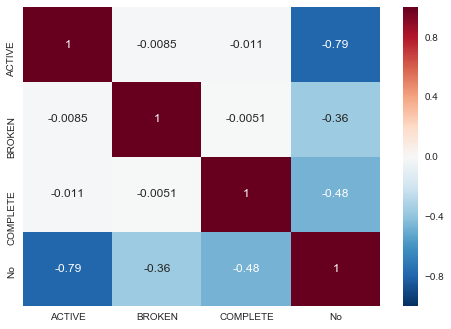

In [22]:
heat_map(status_df)

In [23]:
home_financing_df = excluded_df[['ANY','MORTGAGE','NONE','OWN','RENT']]
home_financing_df.shape

(471402, 5)

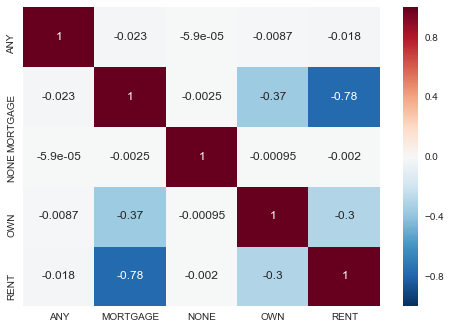

In [24]:
heat_map(home_financing_df)

In [25]:
status_df.head()

,ACTIVE,BROKEN,COMPLETE,No
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


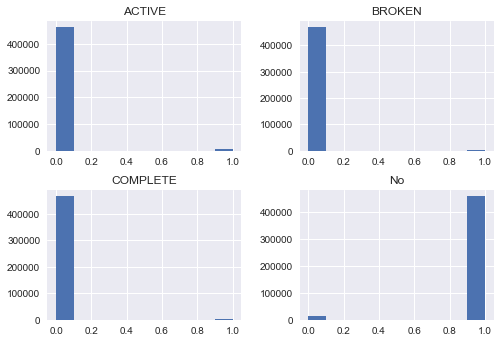

In [26]:
status_df.hist()
plt.show()

In [27]:
groups_df = grouping_df(excluded_df)
len(groups_df)

7

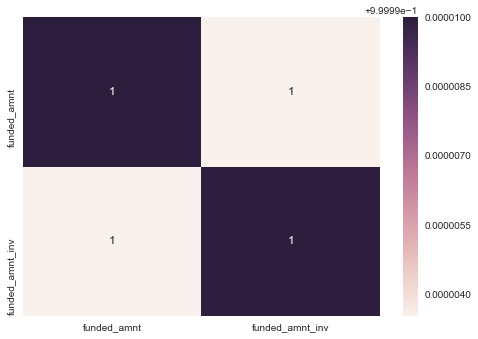

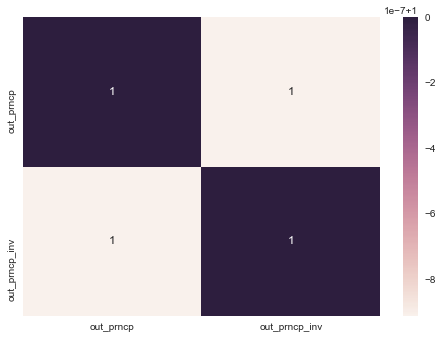

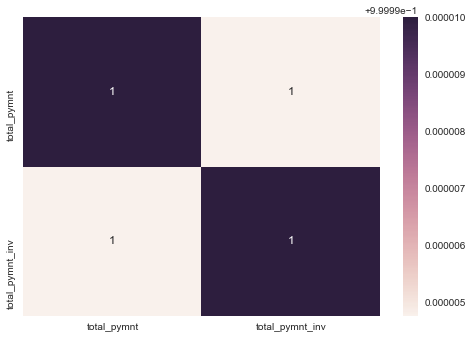

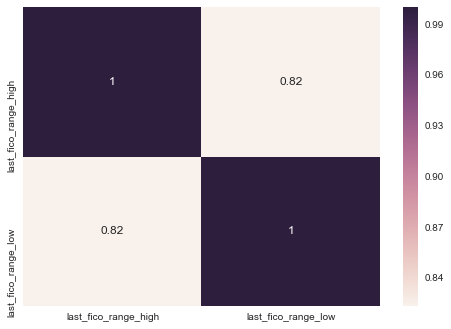

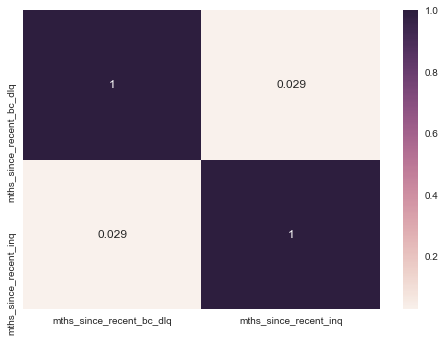

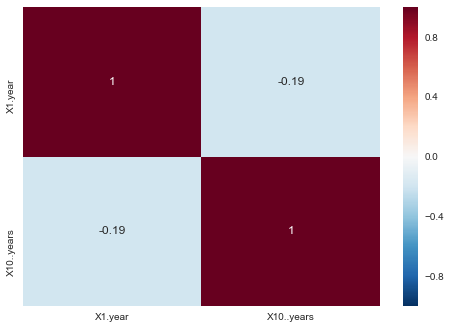

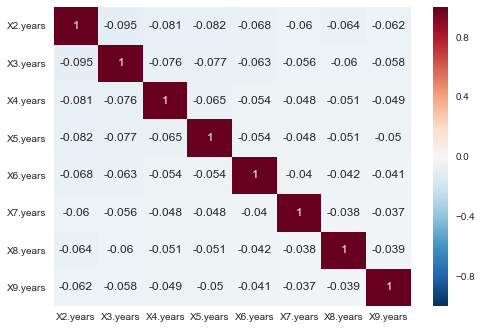

In [28]:
loop_heat_map(groups_df)

In [29]:
feature_importance.head()

,Unnamed: 0,features,rfe_rank,random_forest_importance,random_forest_rank
0,0,X35000.0,140.0,0.000000,140.0
1,1,X40000.0,139.0,0.000000,139.0
2,2,X44500.0,138.0,0.000000,138.0
3,3,X65000.0,137.0,0.000000,137.0
4,4,ANY,49.0,0.000022,128.0


In [30]:
feature_importance.sort_values(by=['random_forest_importance'], ascending=False)

,Unnamed: 0,features,rfe_rank,random_forest_importance,random_forest_rank
105,105,pc_x_3,14.0,1.248507e-01,1.0
110,110,pc_x_8,11.0,7.686128e-02,2.0
111,111,pc_x_9,12.0,7.545544e-02,3.0
109,109,pc_x_7,15.0,6.894905e-02,4.0
107,107,pc_x_5,16.0,6.322335e-02,5.0
117,117,pc_x_15,20.0,5.518281e-02,6.0
148,148,hard_status,NaN,4.282989e-02,NaN
108,108,pc_x_6,17.0,3.599559e-02,7.0
118,118,pc_x_16,22.0,2.988543e-02,8.0
103,103,pc_x_1,37.0,2.901091e-02,9.0


In [31]:
pc_no_dummy

,Unnamed: 0,feature,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,...,pc_28,pc_29,pc_30,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37
0,0,"('loan_amnt',)",0.247304,-0.195157,0.015486,-0.146989,0.013514,-0.076329,0.052069,0.025763,...,-0.019526,0.016170,0.001184,-0.013313,-0.022639,0.001159,0.003246,0.010545,0.018376,0.066986
1,1,"('funded_amnt',)",0.247304,-0.195157,0.015486,-0.146989,0.013514,-0.076329,0.052069,0.025763,...,-0.019526,0.016170,0.001184,-0.013313,-0.022639,0.001159,0.003246,0.010545,0.018376,0.066986
2,2,"('funded_amnt_inv',)",0.247304,-0.195163,0.015452,-0.146984,0.013538,-0.076343,0.052120,0.025771,...,-0.019583,0.016279,0.001182,-0.013400,-0.022707,0.001223,0.003207,0.010535,0.018396,0.067013
3,3,"('int_rate',)",0.003477,-0.145880,0.282281,-0.102496,0.019554,-0.017759,0.043950,-0.132329,...,0.119435,-0.213997,-0.029751,0.056901,-0.021005,-0.180815,0.221631,0.069800,0.044531,0.043417
4,4,"('installment',)",0.233220,-0.193153,0.032142,-0.140837,0.011201,-0.065078,0.028288,0.016780,...,0.053519,-0.152674,-0.019183,0.063234,0.011447,-0.104175,0.107010,0.042030,0.044016,0.086087
5,5,"('annual_inc',)",0.122559,-0.017763,-0.018526,0.105441,-0.063803,0.020935,0.096759,0.037075,...,0.718876,0.215780,0.014312,0.054720,0.036241,0.041639,0.055994,-0.015146,0.020358,0.025980
6,6,"('dti',)",0.030542,0.007662,0.100569,0.048289,0.086831,0.050032,-0.049041,-0.039915,...,0.499400,0.241791,0.017580,-0.020045,-0.048120,0.092098,-0.059341,-0.045089,-0.058231,0.014163
7,7,"('delinq_2yrs',)",0.000966,-0.003401,0.084894,0.095599,-0.241308,-0.252560,-0.130195,0.105912,...,0.023262,0.007387,-0.010624,0.017779,-0.009791,-0.031858,-0.005708,0.062510,0.081119,-0.029797
8,8,"('fico_range_low',)",0.061264,0.108785,-0.280688,-0.062053,0.081990,-0.084377,0.186970,-0.055352,...,0.039728,0.108991,0.003779,0.048237,0.042776,-0.081350,-0.025639,0.033327,0.359334,0.447761
9,9,"('inq_last_6mths',)",0.018794,0.088827,0.135273,-0.080325,-0.127029,0.019326,0.102144,-0.147619,...,-0.064517,0.537808,0.056476,-0.026738,0.031886,-0.188575,0.123025,0.031430,-0.029685,-0.018849


In [32]:
pc_no_dummy.sort_values(by=['pc_1'], ascending=False)

,Unnamed: 0,feature,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,...,pc_28,pc_29,pc_30,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37
0,0,"('loan_amnt',)",0.247304,-0.195157,0.015486,-0.146989,0.013514,-0.076329,0.052069,0.025763,...,-0.019526,0.016170,0.001184,-0.013313,-0.022639,0.001159,0.003246,0.010545,0.018376,0.066986
1,1,"('funded_amnt',)",0.247304,-0.195157,0.015486,-0.146989,0.013514,-0.076329,0.052069,0.025763,...,-0.019526,0.016170,0.001184,-0.013313,-0.022639,0.001159,0.003246,0.010545,0.018376,0.066986
2,2,"('funded_amnt_inv',)",0.247304,-0.195163,0.015452,-0.146984,0.013538,-0.076343,0.052120,0.025771,...,-0.019583,0.016279,0.001182,-0.013400,-0.022707,0.001223,0.003207,0.010535,0.018396,0.067013
20,20,"('total_pymnt_inv',)",0.242144,-0.173102,-0.096328,-0.128474,-0.091472,0.035575,-0.137941,-0.062504,...,-0.021473,0.002718,0.002757,0.026513,0.041358,0.023083,-0.054151,-0.035853,-0.020797,-0.058699
19,19,"('total_pymnt',)",0.242140,-0.173095,-0.096303,-0.128474,-0.091494,0.035584,-0.137981,-0.062490,...,-0.021429,0.002632,0.002761,0.026586,0.041416,0.023035,-0.054126,-0.035850,-0.020824,-0.058731
4,4,"('installment',)",0.233220,-0.193153,0.032142,-0.140837,0.011201,-0.065078,0.028288,0.016780,...,0.053519,-0.152674,-0.019183,0.063234,0.011447,-0.104175,0.107010,0.042030,0.044016,0.086087
21,21,"('total_rec_prncp',)",0.230789,-0.143497,-0.149072,-0.109571,-0.117232,0.060731,-0.173405,-0.058593,...,-0.017388,-0.002415,-0.001144,-0.038194,-0.061585,0.018519,0.012625,-0.026196,-0.008783,-0.051045
33,33,"('total_rev_hi_lim',)",0.212136,0.142855,-0.069344,0.074706,0.153589,-0.001390,0.061431,0.057153,...,-0.116871,0.043576,0.010850,0.065521,-0.011737,-0.020916,0.024396,-0.240966,0.113071,0.120241
60,60,"('total_bc_limit',)",0.203456,0.145035,-0.113881,0.003681,0.167004,-0.042734,0.058563,0.049760,...,0.062706,-0.140640,-0.031388,-0.269470,0.140538,-0.121052,-0.060264,-0.018694,-0.064694,-0.153370
58,58,"('tot_hi_cred_lim',)",0.195704,0.022565,-0.037264,0.289419,-0.115290,0.058062,0.193636,0.001191,...,0.003425,-0.000752,-0.002229,-0.041123,-0.027949,-0.144615,-0.092739,0.055506,-0.040460,0.034673


In [33]:
pca_x_corr(excluded_df, 37)

/Users/mingcao/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/mingcao/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal', 'max_bal_bc', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'num_bc_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies

,Data Variable Comparison,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_28,pc_29,pc_30,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37
0,loan_amnt,0.319743,0.193849,0.060219,0.217522,-0.062740,-0.760488,0.266554,-0.002173,0.329503,...,1.166558e-03,1.460225e-04,4.736205e-05,-1.545714e-05,9.185305e-05,8.217273e-07,8.973829e-07,-8.694774e-07,4.235565e-07,-5.181931e-06
1,funded_amnt,0.319743,0.193849,0.060219,0.217522,-0.062740,-0.760488,0.266554,-0.002173,0.329503,...,1.166558e-03,1.460225e-04,4.736205e-05,-1.545714e-05,9.185305e-05,8.217273e-07,8.973829e-07,-8.694774e-07,4.235565e-07,-5.181931e-06
2,funded_amnt_inv,0.319778,0.193841,0.060183,0.217525,-0.062739,-0.760481,0.266520,-0.002175,0.329514,...,-2.329005e-03,-2.978036e-04,-9.499125e-05,3.398321e-05,-1.830706e-04,-1.705702e-06,-1.473566e-06,2.018856e-06,-7.524546e-07,1.150174e-05
3,int_rate,-0.094871,-0.024527,0.097089,-0.149054,-0.094671,-0.093859,0.199541,0.001720,0.205681,...,-2.077712e-02,3.590291e-03,7.117600e-03,1.161234e-01,-2.912335e-02,2.096689e-02,9.039560e-02,7.641417e-02,-2.800349e-02,-6.759568e-01
4,installment,0.285221,0.193210,0.065725,0.196157,-0.071541,-0.726352,0.279926,-0.002094,0.320725,...,-5.054544e-03,-1.150935e-03,7.797126e-05,-1.738148e-03,-8.602958e-04,-6.291280e-05,-2.305164e-04,-2.208597e-04,-5.187134e-05,-1.006673e-03
5,annual_inc,0.402266,0.900736,-0.153223,-0.056963,0.002108,0.011064,-0.002511,-0.000012,-0.000836,...,1.871814e-09,-3.588129e-09,-3.678544e-11,-2.017691e-09,-1.092398e-09,4.627013e-09,4.524726e-09,4.375005e-10,1.615671e-10,-3.167050e-10
6,dti,0.026478,-0.095494,0.260010,0.038804,0.029648,0.012667,0.066903,-0.002288,0.042993,...,1.312718e-02,-2.709380e-02,-7.085847e-04,-3.349642e-02,-3.668355e-02,6.522025e-01,6.307464e-01,1.905675e-01,9.884285e-03,3.344910e-02
7,delinq_2yrs,0.050002,0.010233,0.014898,-0.085635,0.054138,0.022995,0.042357,-0.001890,-0.001474,...,2.967728e-04,3.990013e-02,1.242396e-04,8.062798e-02,1.990870e-02,-2.892950e-02,2.167762e-02,-2.716164e-02,1.042234e-02,3.170245e-02
8,fico_range_low,0.150058,0.002183,-0.056985,0.323428,0.193674,-0.093377,-0.281723,-0.013612,-0.109038,...,-2.890139e-02,6.590649e-02,1.104604e-03,-6.060253e-01,-1.849141e-02,4.858102e-02,-4.527686e-02,-2.036335e-02,-4.914301e-03,-1.226389e-02
9,inq_last_6mths,0.015104,0.023881,0.032686,0.014704,0.035922,0.043682,-0.054250,0.005729,-0.025183,...,-2.511629e-03,8.190900e-02,1.994576e-04,8.144149e-02,-8.299678e-04,-3.022120e-02,5.240249e-02,-1.022587e-01,-3.120103e-03,-1.382217e-01


In [34]:
charged_state_df = data_exy_new[data_y_newnew['x']=='Charged Off']

In [35]:
charged_state_total = charged_state_df.sum(0)[excluded_x]

In [36]:
state_total = data_exy_new.sum(0)[excluded_x]

In [37]:
sorted_state_values = pd.DataFrame((charged_state_total / state_total).sort_values().dropna(),columns=['ratio'])

In [38]:
%matplotlib qt5

In [39]:
plt.bar(range(50),np.array(sorted_state_values['ratio']))
plt.xticks(range(50),np.array(sorted_state_values.index))
plt.title('Charged Off')
plt.show()

In [40]:
paid_state_df = data_exy_new[data_y_newnew['x']=='Fully Paid']
paid_state_total = paid_state_df.sum(0)[excluded_x]
sorted_paid_state = pd.DataFrame((paid_state_total / state_total).sort_values().dropna(),columns=['ratio'])
plt.bar(range(50),np.array(sorted_paid_state['ratio']))
plt.xticks(range(50),np.array(sorted_paid_state.index))
plt.title('Fully Paid')
plt.show()

In [41]:
grace_state_df = data_exy_new[data_y_newnew['x']=='In Grace Period']
grace_state_total = grace_state_df.sum(0)[excluded_x]
sorted_grace_state = pd.DataFrame((grace_state_total / state_total).sort_values().dropna(),columns=['ratio'])
plt.bar(range(50),np.array(sorted_grace_state['ratio']))
plt.xticks(range(50),np.array(sorted_grace_state.index))
plt.title('In Grace Period')
plt.show()

In [42]:
late_state_df = data_exy_new[data_y_newnew['x']=='Late (16-30 days)']
late_state_total = late_state_df.sum(0)[excluded_x]
sorted_late_state = pd.DataFrame((late_state_total / state_total).sort_values().dropna(),columns=['ratio'])
plt.bar(range(50),np.array(sorted_late_state['ratio']))
plt.xticks(range(50),np.array(sorted_late_state.index))
plt.title('Late (16-30 days)')
plt.show()

In [43]:
late2_state_df = data_exy_new[data_y_newnew['x']=='Late (31-120 days)']
late2_state_total = late2_state_df.sum(0)[excluded_x]
sorted_late2_state = pd.DataFrame((late2_state_total / state_total).sort_values().dropna(),columns=['ratio'])
plt.bar(range(50),np.array(sorted_late2_state['ratio']))
plt.xticks(range(50),np.array(sorted_late2_state.index))
plt.title('Late (31-120 days)')
plt.show()

In [44]:
count = pd.pivot_table(data_y_newnew,index='x',values='level_cor',aggfunc='count')
plt.bar(range(5),count['level_cor'])
plt.xticks(range(5),np.array(count.index))

([<matplotlib.axis.XTick at 0x12287a710>,
 <a list of 5 Text xticklabel objects>)